# K-Nearest Neighbours Binary Classification: Proof of Concept

In this notebook I demonstrate the use of another popular ML algorithm, K-nearest neighbours, as a binary classifier for Genuine and Deceptive reviews over the small ground truth Chicago Hotel dataset.

The accuracies produced in this notebook are not to be trusted as they are based on a very small dataset (1600 samples) with a TINY testing set (480 samples). However, it shows a proof of concept using simple Bag-Of-Words features such as count vectorization and Tf-idf to give a baseline model to improve on with larger datasets and more features.

Without further ado, let's continue.

We start by importing the modules we need.


In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Then, we pull our data files and process them using the Pandas module into easy to manipulate data frames.

In this dataset, we have 1600 samples. 800 are deceptive and 800 are genuine, and there are 400 of each sentiment, positive and negative.

In [14]:
neg_deceptive_folder_path = r"../data/hotels/negative_polarity/deceptive_from_MTurk/"
neg_true_folder_path = r'../data/hotels/negative_polarity/truthful_from_Web/'
pos_deceptive_folder_path = r'../data/hotels/positive_polarity/deceptive_from_MTurk/'
pos_true_folder_path = r'../data/hotels/positive_polarity/truthful_from_TripAdvisor/'

sentiment_class = []
reviews = []
deceptive_class =[]

for i in range(1,6):
    positive_true = pos_true_folder_path + 'fold' + str(i) 
    positive_deceptive = pos_deceptive_folder_path + 'fold' + str(i)
    negative_true = neg_true_folder_path + 'fold' + str(i) 
    negative_deceptive = neg_deceptive_folder_path + 'fold' + str(i) 
    for data_file in sorted(os.listdir(negative_deceptive)):
      sentiment_class.append('negative')
      deceptive_class.append(str(data_file.split('_')[0]))
      with open(os.path.join(negative_deceptive, data_file)) as f:
        contents = f.read()
        reviews.append(contents)
    for data_file in sorted(os.listdir(negative_true)):
      sentiment_class.append('negative')
      deceptive_class.append(str(data_file.split('_')[0]))
      with open(os.path.join(negative_true, data_file)) as f:
        contents = f.read()
        reviews.append(contents)
    for data_file in sorted(os.listdir(positive_deceptive)):
      sentiment_class.append('positive')
      deceptive_class.append(str(data_file.split('_')[0]))
      with open(os.path.join(positive_deceptive, data_file)) as f:
        contents = f.read()
        reviews.append(contents)
    for data_file in sorted(os.listdir(positive_true)):
      sentiment_class.append('positive')
      deceptive_class.append(str(data_file.split('_')[0]))
      with open(os.path.join(positive_true, data_file)) as f:
        contents = f.read()
        reviews.append(contents)


df = pd.DataFrame({'sentiment':sentiment_class,'review':reviews,'deceptive':deceptive_class})

df.loc[df['deceptive']=='d','deceptive']=1
df.loc[df['deceptive']=='t','deceptive']=0

df.loc[df['sentiment']=='positive','sentiment']=1
df.loc[df['sentiment']=='negative','sentiment']=0

X = df['review']

y = np.asarray(df['deceptive'],dtype=int)

Then, we split our data into training and testing. Experiment shows that 70/30 split is ideal. The random_state parameter lets us shuffle our data randomly.

In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

cv = CountVectorizer()
tfidf = TfidfTransformer()

In [17]:
X_train_count = cv.fit_transform(X_train) # Transforming the Training reviews to count vectors and fitting for TF-idf
X_test_count = cv.transform(X_test) # Only transforming the test reviews to count vectors

X_train_tfidf = tfidf.fit_transform(X_train_count) # Transforming the fitted training Count Vectors to Tfidf vectors
X_test_tfidf = tfidf.transform(X_test_count) # Transforming test count vectors to tf-df vectors

In [18]:
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,14)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train_tfidf, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train_tfidf, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test_tfidf, y_test) 

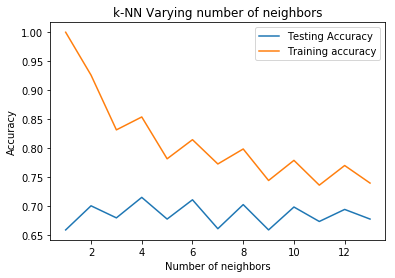

In [19]:
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

6 seems to be our best amount of neighbours. Let's roll with that one.

In [23]:
knn = KNeighborsClassifier(n_neighbors=6)

knn.fit(X_train_tfidf ,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

In [24]:
y_predictions = knn.predict(X_test_tfidf)

In [25]:
from sklearn import metrics

yp=["Genuine" if prediction == 0 else "Deceptive" for prediction in list(y_predictions)]
output_fm = pd.DataFrame({'Review':list(X_test) ,'Genuine(0)/Deceptive(1)':yp})
print(output_fm)
print(metrics.classification_report(y_test, y_predictions, target_names=set(yp)))

print("Overall accuracy: ", knn.score(X_test_tfidf, y_test))


                                                Review Genuine(0)/Deceptive(1)
0    I traveled to Chicago recently with my giant G...               Deceptive
1    The Ambassador Hotel is located in Downtown Ch...                 Genuine
2    I stayed here for a weekend while visiting som...               Deceptive
3    My wife and I brought our daughter downtown fo...                 Genuine
4    Booked this on priceline for an insanely low p...                 Genuine
5    We arrived for a weekend stay and really enjoy...               Deceptive
6    This is a great hotel! The views are fabulous,...                 Genuine
7    Couldn't have asked for a better home base for...               Deceptive
8    Just back from spending Memorial Day weekend i...               Deceptive
9    Don't ever stay at this hotel!, Conrad Chicago...               Deceptive
10   The Ambassador East Hotel is a business that c...               Deceptive
11   I just had a conference there. They have bed b.